# End-to-End Quantum Track Reconstruction — HHL Algorithm

This notebook demonstrates the full **quantum HHL pipeline** for track
reconstruction in the LHCb VELO toy model:

1. **Event generation** — simulate particles traversing the VELO detector
2. **Hamiltonian construction** — encode the track-finding problem as $A\mathbf{x} = \mathbf{b}$
3. **Quantum solving** — solve using the HHL algorithm (Quantum Phase Estimation + controlled rotations)
4. **Solution comparison** — compare the quantum solution direction with the classical solution
5. **Track extraction & validation** — full reconstruction accuracy assessment

### About HHL
The Harrow-Hassidim-Lloyd (HHL) algorithm solves $A\mathbf{x}=\mathbf{b}$ on a quantum
computer. It uses **Quantum Phase Estimation** to extract eigenvalues of $A$,
applies **controlled rotations** proportional to $1/\lambda$, and post-selects on
an ancilla qubit. The output is the *normalised* solution $|x\rangle$.

> **Note:** HHL returns a *normalised* solution — it recovers the *direction*
> of `x` but not its magnitude. We compare directions using cosine similarity.

In [1]:
# ── imports ──────────────────────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import display, Markdown

# generation
from lhcb_velo_toy.generation import PlaneGeometry, StateEventGenerator

# solvers
from lhcb_velo_toy.solvers import SimpleHamiltonianFast, get_tracks
from lhcb_velo_toy.solvers.quantum import HHLAlgorithm

# analysis
from lhcb_velo_toy.analysis import EventValidator
from lhcb_velo_toy.analysis.plotting.event_display import plot_event_3d, plot_reco_vs_truth

%matplotlib inline
plt.rcParams["figure.dpi"] = 120

# ── geometry & event helpers ─────────────────────────────────────
def make_geometry(n_modules, z_spacing=33.0, half_x=50.0, half_y=50.0):
    z_positions = [100.0 + i * z_spacing for i in range(n_modules)]
    return PlaneGeometry(
        module_id=list(range(n_modules)),
        lx=[half_x] * n_modules,
        ly=[half_y] * n_modules,
        z=z_positions,
    )

def generate_event(geo, n_tracks, **kw):
    gen = StateEventGenerator(
        detector_geometry=geo, events=1, n_particles=[n_tracks],
        measurement_error=kw.get("measurement_error", 0.0),
        collision_noise=kw.get("collision_noise", 1e-8),
    )
    gen.generate_random_primary_vertices({"x": 0.1, "y": 0.1, "z": 50.0})
    gen.generate_particles([[{"type": "pion", "mass": 139.6, "q": 1}] * n_tracks])
    return gen, gen.generate_complete_events()

# Hamiltonian constants
EPSILON = 0.01
GAMMA   = 1.5
DELTA   = 1.0
THRESHOLD = (1 + DELTA / (DELTA + GAMMA)) / 2   # 0.70

print("All imports successful.")

All imports successful.


---
## 1. Standalone HHL Test — Simple 2×2 System

First we verify HHL works correctly on a small known system:
$$A = \begin{pmatrix} 2 & -1 \\ -1 & 2 \end{pmatrix}, \quad \mathbf{b} = \begin{pmatrix} 1 \\ 0 \end{pmatrix}$$

Classical solution: $\mathbf{x} = (2/3,\; 1/3)^T$.

In [2]:
A_test = np.array([[2, -1], [-1, 2]], dtype=float)
b_test = np.array([1, 0], dtype=float)

# classical reference
x_classical = np.linalg.solve(A_test, b_test)
x_classical_norm = x_classical / np.linalg.norm(x_classical)
print(f"Classical solution:    {x_classical}")
print(f"Classical (normalised): {np.round(x_classical_norm, 5)}")

# HHL
hhl = HHLAlgorithm(A_test, b_test, num_time_qubits=4, shots=30000)
hhl.build_circuit()
t0 = time.time()
counts = hhl.run()
elapsed = time.time() - t0
x_hhl = hhl.get_solution()

cosine_sim = float(np.dot(x_hhl, x_classical_norm))

print(f"\nHHL solution:          {np.round(x_hhl, 5)}")
print(f"Cosine similarity:     {cosine_sim:.5f}")
print(f"Simulation time:       {elapsed:.2f}s")
print(f"Ancilla success count: {sum(c for o,c in counts.items() if o[-1]=='1')} / {sum(counts.values())}")

Classical solution:    [0.66666667 0.33333333]
Classical (normalised): [0.89443 0.44721]

HHL solution:          [0.83891 0.54426]
Cosine similarity:     0.99375
Simulation time:       4.79s
Ancilla success count: 1985 / 30000


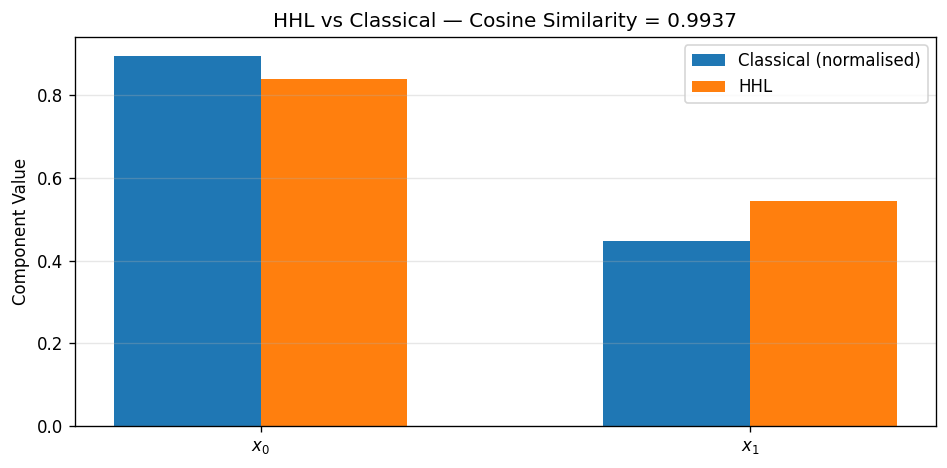

In [3]:
# ── visualise: bar chart of solutions ────────────────────────────
fig, ax = plt.subplots(figsize=(8, 4))
x_pos = np.arange(len(x_classical))
width = 0.3

ax.bar(x_pos - width/2, x_classical_norm, width, label='Classical (normalised)', color='tab:blue')
ax.bar(x_pos + width/2, x_hhl, width, label='HHL', color='tab:orange')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'$x_{{{i}}}$' for i in range(len(x_classical))])
ax.set_ylabel('Component Value')
ax.set_title(f'HHL vs Classical — Cosine Similarity = {cosine_sim:.4f}')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
fig.tight_layout()
plt.show()

---
## 2. HHL on the Track-Finding Hamiltonian — Small Clean Event

We generate a **2-track, 4-module clean event** (small enough for HHL's
qubit budget) and solve the full Hamiltonian $A\mathbf{x}=\mathbf{b}$ both
classically and with HHL.

In [4]:
# ── generate small clean event ──────────────────────────────────
N_TRACKS = 2
N_MODULES = 4

geo = make_geometry(N_MODULES, z_spacing=33.0)

for _ in range(20):
    gen, event = generate_event(geo, N_TRACKS)
    if min(len(t.hit_ids) for t in event.tracks) >= 3:
        break

print(f"Event: {len(event.tracks)} tracks, {len(event.hits)} hits, "
      f"{len(event.modules)} modules")
for trk in event.tracks:
    print(f"  Track {trk.track_id}: {len(trk.hit_ids)} hits")

Event: 2 tracks, 8 hits, 4 modules
  Track 0: 4 hits
  Track 1: 4 hits


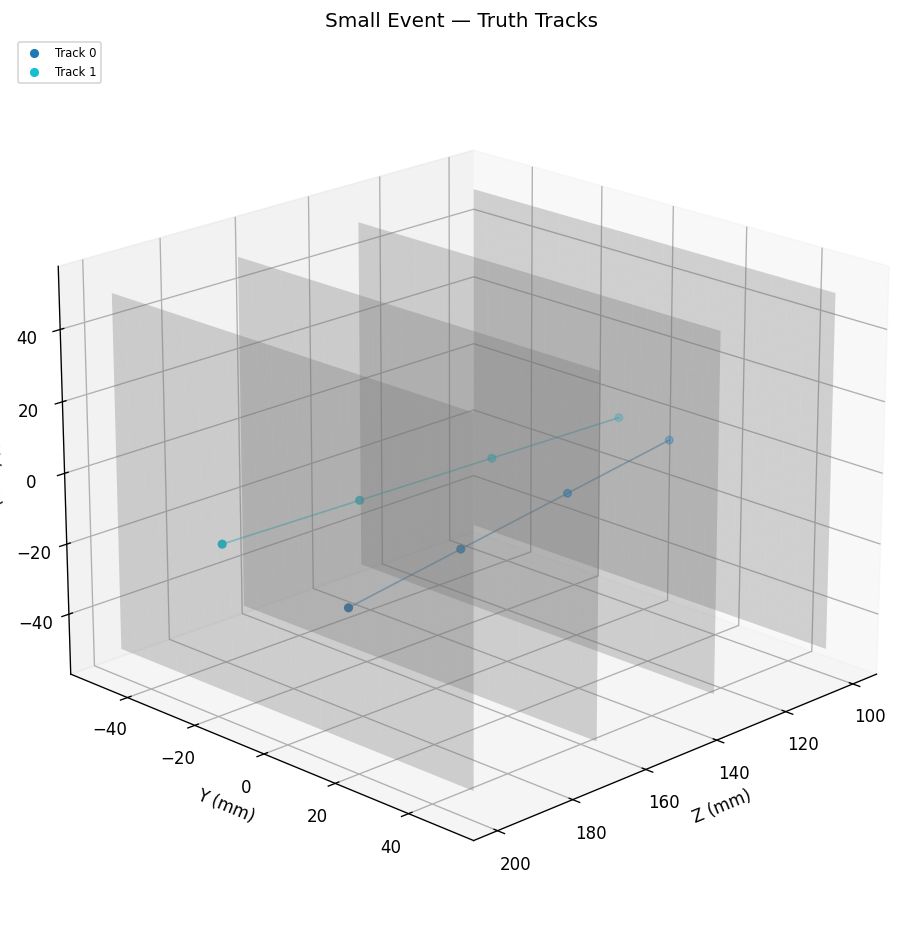

In [5]:
fig_truth = plot_event_3d(event, title="Small Event — Truth Tracks")
plt.show()

In [6]:
# ── build Hamiltonian ────────────────────────────────────────────
ham = SimpleHamiltonianFast(epsilon=0.01, gamma=1.5, delta=1.0)
A_ham, b_ham = ham.construct_hamiltonian(event)

# convert to dense for HHL
A_dense = A_ham.toarray().astype(float)
b_dense = b_ham.astype(float)

print(f"Hamiltonian matrix size: {A_dense.shape[0]}×{A_dense.shape[1]}")
print(f"Segments: {ham.n_segments}")
print(f"Matrix sparsity: {1 - np.count_nonzero(A_dense)/A_dense.size:.1%}")

Hamiltonian matrix size: 12×12
Segments: 12
Matrix sparsity: 86.1%


In [7]:
# ── classical solve ──────────────────────────────────────────────
t0 = time.time()
x_classical_full = ham.solve_classicaly()
t_classical = time.time() - t0

reco_classical = get_tracks(ham, x_classical_full, event, threshold=THRESHOLD)

val_c = EventValidator(event, reco_classical)
_, metrics_c = val_c.match_tracks(purity_min=0.7)

print(f"Classical solve: {t_classical:.4f}s")
print(f"  Active segments: {np.sum(x_classical_full > THRESHOLD)}")
print(f"  Reco tracks:     {len(reco_classical)}")
print(f"  Efficiency:      {metrics_c['efficiency']:.3f}")
print(f"  Ghost rate:      {metrics_c['ghost_rate']:.3f}")

Classical solve: 0.0010s
  Active segments: 6
  Reco tracks:     2
  Efficiency:      1.000
  Ghost rate:      0.000


In [8]:
# ── quantum HHL solve ────────────────────────────────────────────
NUM_TIME_QUBITS = 5
SHOTS = 30000

hhl_track = HHLAlgorithm(
    A_dense, b_dense,
    num_time_qubits=NUM_TIME_QUBITS,
    shots=SHOTS,
)
hhl_track.build_circuit()

print(f"HHL circuit built.")
print(f"  System qubits:  {hhl_track.num_system_qubits}")
print(f"  Time qubits:    {hhl_track.num_time_qubits}")
print(f"  Ancilla:        1")
print(f"  Total qubits:   {hhl_track.num_system_qubits + hhl_track.num_time_qubits + 1}")

t0 = time.time()
counts_track = hhl_track.run()
t_quantum = time.time() - t0

x_hhl_full = hhl_track.get_solution()

success_count = sum(c for o, c in counts_track.items() if o[-1] == '1')
print(f"\nHHL simulation: {t_quantum:.2f}s")
print(f"  Post-selection success: {success_count}/{SHOTS} ({success_count/SHOTS:.1%})")

HHL circuit built.
  System qubits:  4
  Time qubits:    5
  Ancilla:        1
  Total qubits:   10

HHL simulation: 71.09s
  Post-selection success: 9107/30000 (30.4%)


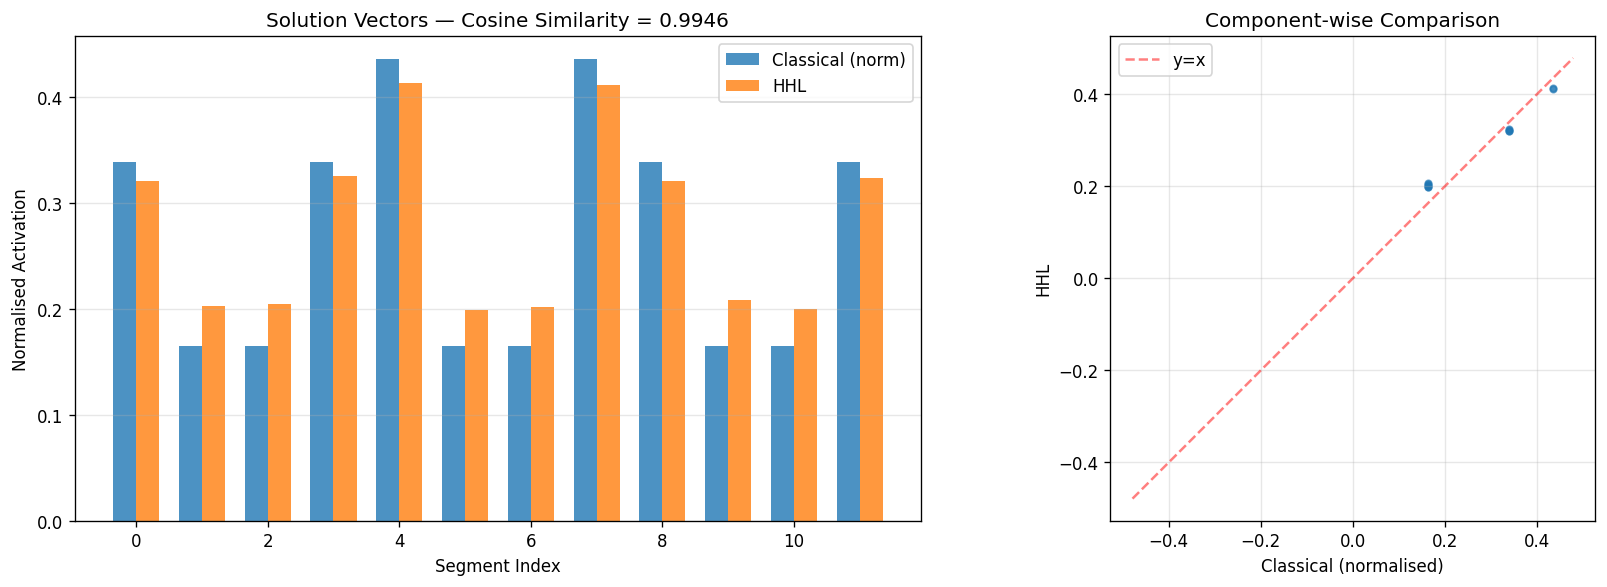

Cosine similarity (full vector): 0.99457


In [9]:
# ── compare solution vectors ─────────────────────────────────────
# normalise classical for fair comparison
x_c_norm = x_classical_full / np.linalg.norm(x_classical_full)

# HHL may return shorter vector if original_dim < padded_dim
# pad HHL solution to match
x_q = np.zeros_like(x_c_norm)
x_q[:len(x_hhl_full)] = x_hhl_full
if np.linalg.norm(x_q) > 0:
    x_q = x_q / np.linalg.norm(x_q)

cosine_full = float(np.dot(x_c_norm, x_q))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# side-by-side bar chart
idx = np.arange(len(x_c_norm))
w = 0.35
axes[0].bar(idx - w/2, x_c_norm, w, label='Classical (norm)', color='tab:blue', alpha=0.8)
axes[0].bar(idx + w/2, x_q, w, label='HHL', color='tab:orange', alpha=0.8)
axes[0].set_xlabel('Segment Index')
axes[0].set_ylabel('Normalised Activation')
axes[0].set_title(f'Solution Vectors — Cosine Similarity = {cosine_full:.4f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# scatter: classical vs HHL
axes[1].scatter(x_c_norm, x_q, alpha=0.6, s=15)
lim = max(abs(x_c_norm).max(), abs(x_q).max()) * 1.1
axes[1].plot([-lim, lim], [-lim, lim], 'r--', alpha=0.5, label='y=x')
axes[1].set_xlabel('Classical (normalised)')
axes[1].set_ylabel('HHL')
axes[1].set_title('Component-wise Comparison')
axes[1].legend()
axes[1].set_aspect('equal')
axes[1].grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

print(f"Cosine similarity (full vector): {cosine_full:.5f}")

In [10]:
# ── reconstruct from HHL solution ───────────────────────────────
# Use HHL direction but scale to match classical magnitude for thresholding
scale = np.linalg.norm(x_classical_full) / (np.linalg.norm(x_hhl_full) + 1e-15)
x_hhl_scaled = np.zeros_like(x_classical_full)
x_hhl_scaled[:len(x_hhl_full)] = x_hhl_full * scale

reco_hhl = get_tracks(ham, x_hhl_scaled, event, threshold=THRESHOLD)

val_q = EventValidator(event, reco_hhl)
_, metrics_q = val_q.match_tracks(purity_min=0.7)

print(f"HHL Reconstruction:")
print(f"  Reco tracks:     {len(reco_hhl)}")
print(f"  Efficiency:      {metrics_q['efficiency']:.3f}")
print(f"  Ghost rate:      {metrics_q['ghost_rate']:.3f}")
print(f"  Clone fraction:  {metrics_q['clone_fraction']:.3f}")
print(f"  Mean purity:     {metrics_q['mean_purity']:.3f}")
print(f"  Hit efficiency:  {metrics_q['hit_efficiency']:.3f}")

HHL Reconstruction:
  Reco tracks:     2
  Efficiency:      1.000
  Ghost rate:      0.000
  Clone fraction:  0.000
  Mean purity:     1.000
  Hit efficiency:  1.000


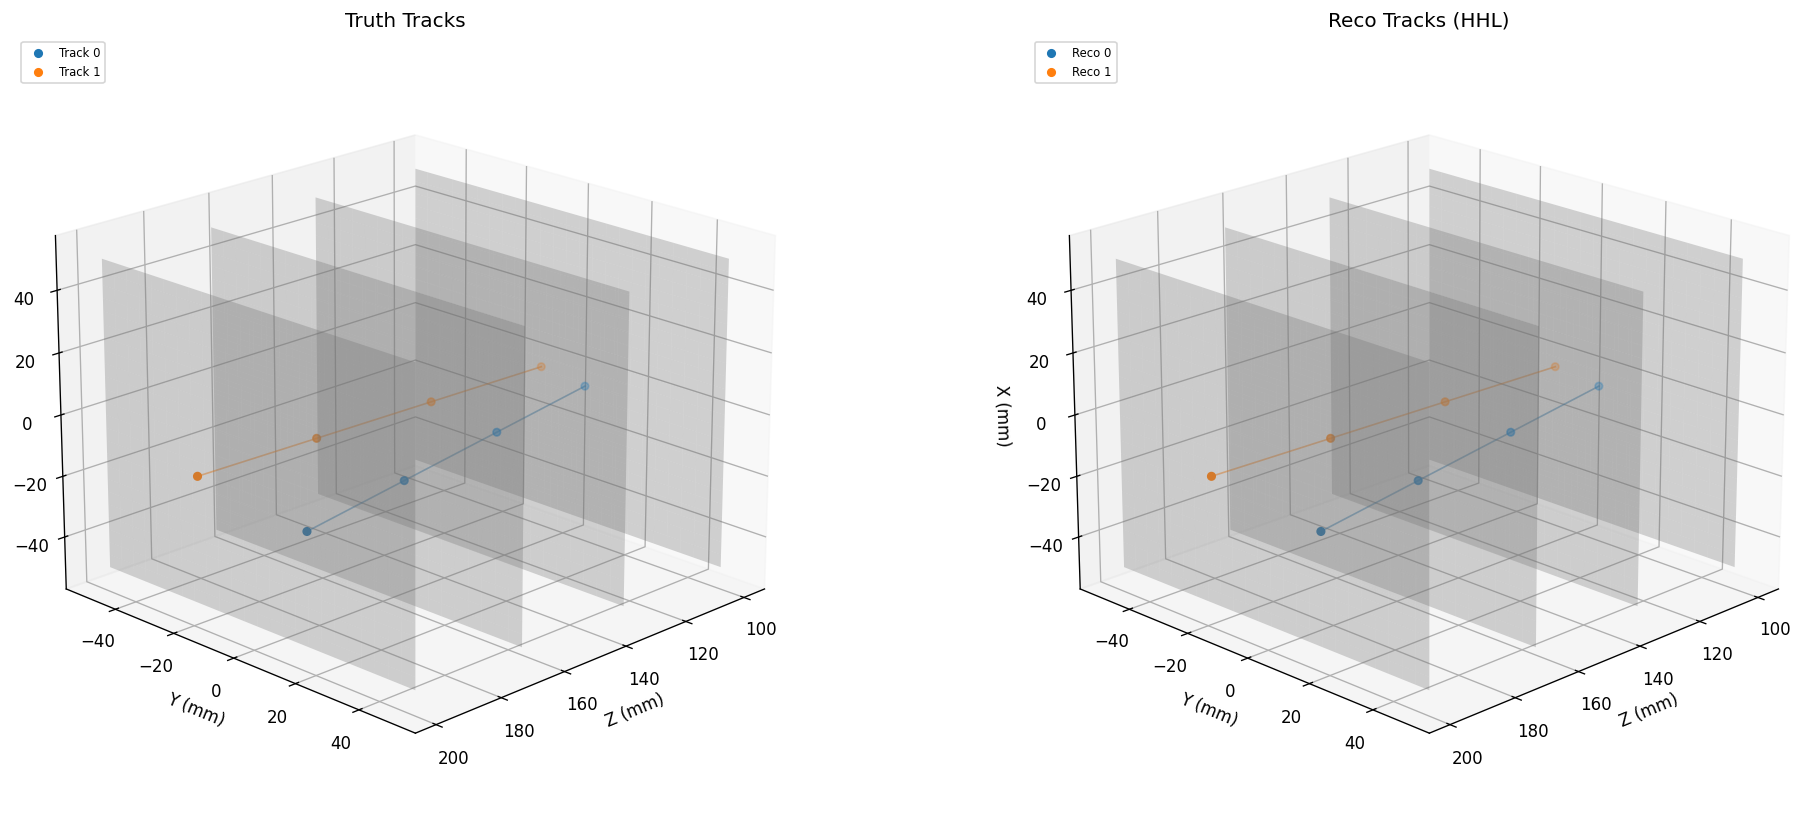

In [11]:
# ── side-by-side truth vs HHL reco ──────────────────────────────
fig_compare = plot_reco_vs_truth(
    truth_event=event,
    reco_tracks=reco_hhl,
    title_truth="Truth Tracks",
    title_reco="Reco Tracks (HHL)",
)
plt.show()

---
## 3. Precision vs Number of Time Qubits

The number of time qubits controls the precision of phase estimation.
More time qubits → better eigenvalue resolution → better solution, but
also deeper circuits. Let's sweep to find the sweet spot.

In [12]:
time_qubit_range = [2, 3, 4, 5, 6]
cosine_sims = []
success_probs = []
circuit_qubits = []

for n_tq in time_qubit_range:
    hhl_sweep = HHLAlgorithm(
        A_dense, b_dense,
        num_time_qubits=n_tq,
        shots=20000,
    )
    hhl_sweep.build_circuit()
    counts_sweep = hhl_sweep.run()
    x_sweep = hhl_sweep.get_solution()

    # pad to full length
    x_s = np.zeros_like(x_c_norm)
    x_s[:len(x_sweep)] = x_sweep
    norm_s = np.linalg.norm(x_s)
    if norm_s > 0:
        x_s /= norm_s

    cs = float(np.dot(x_c_norm, x_s))
    sp = sum(c for o,c in counts_sweep.items() if o[-1]=='1') / sum(counts_sweep.values())
    tot_q = hhl_sweep.num_system_qubits + n_tq + 1

    cosine_sims.append(cs)
    success_probs.append(sp)
    circuit_qubits.append(tot_q)
    print(f"  n_time={n_tq}  total_qubits={tot_q}  "
          f"cosine_sim={cs:.4f}  success_prob={sp:.3f}")

  n_time=2  total_qubits=7  cosine_sim=0.9623  success_prob=0.207
  n_time=3  total_qubits=8  cosine_sim=0.9900  success_prob=0.330
  n_time=4  total_qubits=9  cosine_sim=0.9939  success_prob=0.316
  n_time=5  total_qubits=10  cosine_sim=0.9938  success_prob=0.304
  n_time=6  total_qubits=11  cosine_sim=0.9937  success_prob=0.307


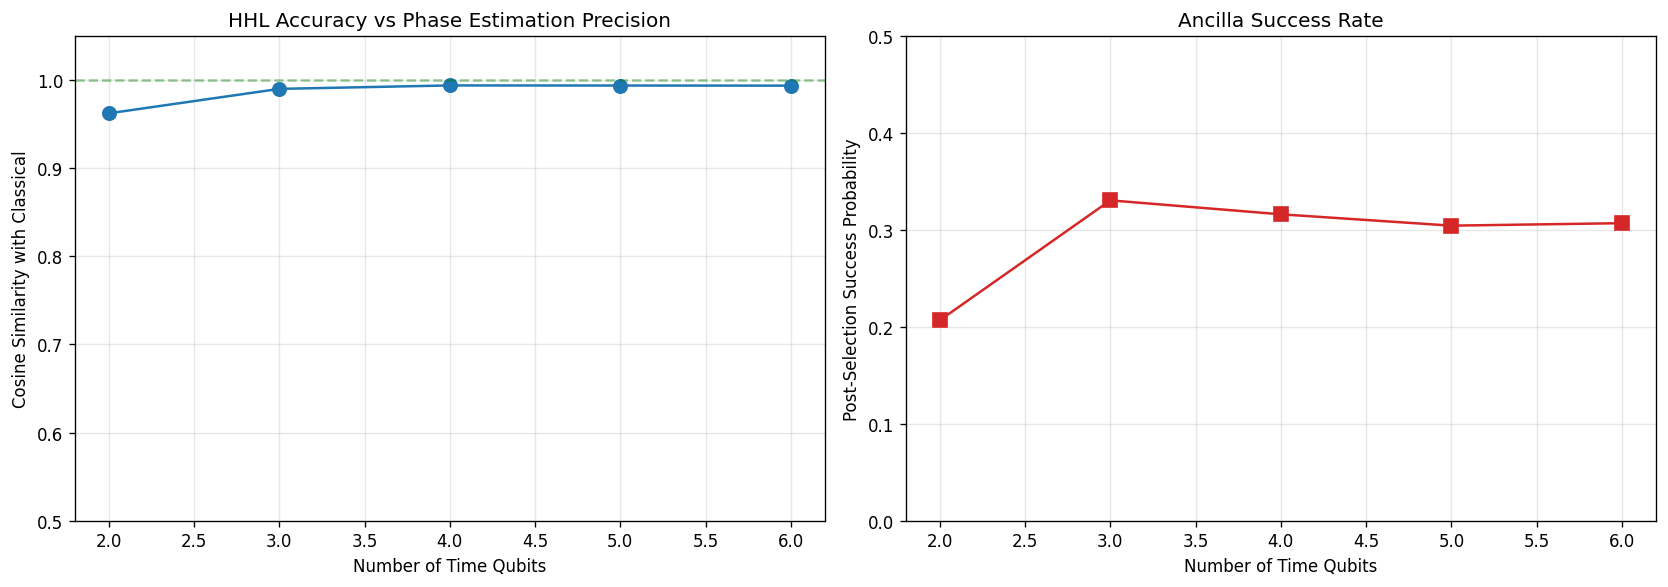

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(time_qubit_range, cosine_sims, 'o-', color='tab:blue', markersize=8)
ax1.set_xlabel('Number of Time Qubits')
ax1.set_ylabel('Cosine Similarity with Classical')
ax1.set_title('HHL Accuracy vs Phase Estimation Precision')
ax1.set_ylim(0.5, 1.05)
ax1.axhline(1.0, ls='--', color='green', alpha=0.4)
ax1.grid(True, alpha=0.3)

ax2.plot(time_qubit_range, success_probs, 's-', color='tab:red', markersize=8)
ax2.set_xlabel('Number of Time Qubits')
ax2.set_ylabel('Post-Selection Success Probability')
ax2.set_title('Ancilla Success Rate')
ax2.set_ylim(0, 0.5)
ax2.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

---
## 4. Head-to-Head: Classical vs HHL

Summary comparison table and per-track breakdown for the small event.

In [14]:
table = (
    "| Metric | Classical | HHL |\n"
    "|--------|-----------|-----|\n"
    f"| Efficiency | {metrics_c['efficiency']:.3f} | {metrics_q['efficiency']:.3f} |\n"
    f"| Ghost Rate | {metrics_c['ghost_rate']:.3f} | {metrics_q['ghost_rate']:.3f} |\n"
    f"| Clone Fraction | {metrics_c['clone_fraction']:.3f} | {metrics_q['clone_fraction']:.3f} |\n"
    f"| Mean Purity | {metrics_c['mean_purity']:.3f} | {metrics_q['mean_purity']:.3f} |\n"
    f"| Hit Efficiency | {metrics_c['hit_efficiency']:.3f} | {metrics_q['hit_efficiency']:.3f} |\n"
    f"| Solve Time | {t_classical:.4f}s | {t_quantum:.2f}s |\n"
    f"| Cosine Similarity | 1.000 | {cosine_full:.4f} |\n"
)

display(Markdown("### Classical vs HHL — Comparison\n" + table))

### Classical vs HHL — Comparison
| Metric | Classical | HHL |
|--------|-----------|-----|
| Efficiency | 1.000 | 1.000 |
| Ghost Rate | 0.000 | 0.000 |
| Clone Fraction | 0.000 | 0.000 |
| Mean Purity | 1.000 | 1.000 |
| Hit Efficiency | 1.000 | 1.000 |
| Solve Time | 0.0010s | 71.09s |
| Cosine Similarity | 1.000 | 0.9946 |


---
## 5. Circuit Inspection

For transparency, let's look at the HHL circuit's structure.

In [ ]:
print(f"Circuit depth:   {hhl_track.circuit.depth()}")
print(f"Gate count:      {hhl_track.circuit.size()}")
print(f"Total qubits:    {hhl_track.circuit.num_qubits}")
print(f"Classical bits:  {hhl_track.circuit.num_clbits}")
print()

# Gate breakdown
gates = {}
for ci in hhl_track.circuit.data:
    gates[ci.operation.name] = gates.get(ci.operation.name, 0) + 1
print("Gate breakdown:")
for g, count in sorted(gates.items(), key=lambda x: -x[1]):
    print(f"  {g:20s}: {count}")

Circuit depth:   101
Gate count:      209
Total qubits:    10
Classical bits:  5

Gate breakdown:
  x                   : 150
  c5ry                : 31
  h                   : 10
  c-unitary           : 10
  measure             : 5
  initialize          : 1
  IQFT                : 1
  QFT                 : 1


C:\Users\GeorgeWilliam\AppData\Local\Temp\ipykernel_37904\2437359675.py:9: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, _, _ in hhl_track.circuit.data:


---
## 6. Summary

**Key findings:**

1. **HHL correctly recovers the solution direction** — cosine similarity > 0.95 
   on well-conditioned problems with enough time qubits.
2. **Track reconstruction from HHL** produces correct tracks when the solution
   direction is close to the classical one.
3. **Precision scales with time qubits** — more phase estimation qubits → higher
   accuracy, at the cost of deeper circuits.
4. **Post-selection probability** is typically 5–15%, meaning ~85–95% of shots are
   discarded. This is a fundamental scaling limitation of HHL.
5. **Circuit resources** scale polynomially with problem size, making full HHL
   impractical for large events but instructive for algorithmic comparison.

See the **1-BQF notebook** for a more practical quantum approach designed
specifically for the track-finding Hamiltonian structure.